## XGB Experiments

In [ ]:
# Note that the model was trained on T4 GPU on Google colab. Have tried to tidy up the codes to run on Jupyter notebook as far as possible. 

In [ ]:
!pip install gensim
!pip install optuna
!pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 req

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 22.0 MB/s eta 0:00:00


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import random
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score
import optuna
from optuna.samplers import TPESampler
import joblib
from xgboost import XGBClassifier

In [ ]:
random.seed(42)
np.random.seed(42)

- Load the train and test files

In [ ]:
train_df = pd.read_csv("train_data.csv")
val_df  = pd.read_csv("val_data.csv")
test_df  = pd.read_csv("test_data.csv")


import pandas as pd

In [ ]:
print(f"Train: {len(train_df):>6} rows")
print(f" Val : {len(val_df):>6} rows")
print(f" Test: {len(test_df):>6} rows")

Train:   8000 rows
 Val :   1000 rows
 Test:   1000 rows


## DistilBERT (Extract embeddings using fine-tuned DistilBERT w preprocessing)

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.nn import CrossEntropyLoss
import evaluate
from sklearn.metrics import accuracy_score, classification_report
import torch
from transformers import AutoTokenizer, DistilBertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import joblib
import re
import nltk
from nltk.corpus import stopwords

- Text preprocessing

In [ ]:
train_texts = train_df["text"].astype(str).tolist()
val_texts   = val_df["text"].astype(str).tolist()
train_labels = train_df["sentiment_id"].tolist()
val_labels   = val_df["sentiment_id"].tolist()

- Fine-tuning DistilBERT

In [ ]:
cuda_available = torch.cuda.is_available()
mps_available  = getattr(torch.backends.mps, "is_available", lambda: False)()

if cuda_available:
    device = "cuda"
elif mps_available:
    device = "mps"
else:
    device = "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
# compute balanced class weights
classes = np.unique(train_labels)
weights = compute_class_weight("balanced", classes=classes, y=train_labels)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

In [ ]:
# tokenize
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, padding=True, truncation=True)
val_encodings   = tokenizer(val_texts,   padding=True, truncation=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset   = SentimentDataset(val_encodings, val_labels)

In [ ]:
metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")
metric_f1        = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = metric_accuracy.compute(predictions=preds, references=labels)["accuracy"]
    prec = metric_precision.compute(
        predictions=preds,
        references=labels,
        average="macro"
    )["precision"]
    rec = metric_recall.compute(
        predictions=preds,
        references=labels,
        average="macro"
    )["recall"]
    f1 = metric_f1.compute(
        predictions=preds,
        references=labels,
        average="macro"
    )["f1"]


    return {
        "Accuracy":  acc,
        "Precision": prec,
        "Recall":    rec,
        "F1":        f1,
    }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results_distilbert_experiment3',
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="F1",
    greater_is_better=True,
    logging_dir="./logs",
)

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits  = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(
            logits.view(-1, model.config.num_labels),
            labels.view(-1)
        )
        return (loss, outputs) if return_outputs else loss

In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: belinda_lim_88 (belinda_lim_88-singapore-management-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.708200,0.585190,0.850000,0.737201,0.775429,0.739616
2,0.517800,0.735447,0.874000,0.753760,0.764320,0.757407
3,0.324700,0.925222,0.872000,0.742657,0.763031,0.751514


TrainOutput(global_step=3000, training_loss=0.5169187316894531, metrics={'train_runtime': 1642.363, 'train_samples_per_second': 14.613, 'train_steps_per_second': 1.827, 'total_flos': 3179274264576000.0, 'train_loss': 0.5169187316894531, 'epoch': 3.0})

In [ ]:
# save best model and tokenizer
trainer.save_model("distilbert_experiment2")
tokenizer.save_pretrained("distilbert_experiment2")

('distilbert_experiment2/tokenizer_config.json',
 'distilbert_experiment2/special_tokens_map.json',
 'distilbert_experiment2/vocab.txt',
 'distilbert_experiment2/added_tokens.json',
 'distilbert_experiment2/tokenizer.json')

In [ ]:
model     = DistilBertForSequenceClassification.from_pretrained("distilbert_experiment2").to(device)
tokenizer = AutoTokenizer.from_pretrained("distilbert_experiment2")

inference_trainer = Trainer(
    model=model,
    tokenizer=tokenizer)

/tmp/ipython-input-19-1083177105.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  inference_trainer = Trainer(


In [ ]:
# Run predict on validation dataset
pred_output = inference_trainer.predict(val_dataset)

# compute predictions
logits = pred_output.predictions
y_true = pred_output.label_ids
y_pred = np.argmax(logits, axis=1)

# classification report
print(classification_report(y_true,y_pred,target_names=["Negative", "Neutral", "Positive"],digits=4))

              precision    recall  f1-score   support

    Negative     0.8133    0.7625    0.7871       160
     Neutral     0.5000    0.5941    0.5430       101
    Positive     0.9479    0.9364    0.9421       739

    accuracy                         0.8740      1000
   macro avg     0.7538    0.7643    0.7574      1000
weighted avg     0.8812    0.8740    0.8770      1000



- Extract train and validation embeddings using fine-tuned model

In [ ]:
# reload fine-tuned tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert_experiment2")
model     = DistilBertForSequenceClassification.from_pretrained("distilbert_experiment2").to(device)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
def get_embeddings(texts, batch_size=32):
    all_embeds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        enc = tokenizer(batch, return_tensors="pt",
                        padding=True, truncation=True).to(device)
        with torch.no_grad():
            out = model.distilbert(**enc) # run the encoder of fine-tuned distilbert
        cls_emb = out.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeds.append(cls_emb)
    return np.vstack(all_embeds)

In [ ]:
X_train_embeds_1 = get_embeddings(train_texts)
joblib.dump(X_train_embeds_1, "X_train_embeds_distilbert_finetuned_experiment2.pkl")

['X_train_embeds_distilbert_finetuned_experiment2.pkl']

In [ ]:
joblib.dump(
   X_train_embeds_1,
    "X_train_embeds_distilbert_finetuned_experiment2.pkl"
)

['/content/drive/MyDrive/X_train_embeds_distilbert_finetuned_experiment2.pkl']

In [ ]:
X_val_embeds_1   = get_embeddings(val_texts)
joblib.dump(X_val_embeds_1,   "X_val_embeds_distilbert_finetuned_experiment2.pkl")

['X_val_embeds_distilbert_finetuned_experiment2.pkl']

In [ ]:
joblib.dump(
   X_val_embeds_1,
    "X_val_embeds_distilbert_finetuned_experiment2.pkl"
)

['/content/drive/MyDrive/X_val_embeds_distilbert_finetuned_experiment2.pkl']

- Hyperparameter Tuning

In [ ]:
X_train_embeds_1 = joblib.load("X_train_embeds_distilbert_finetuned_experiment2.pkl")
X_val_embeds_1   = joblib.load("X_val_embeds_distilbert_finetuned_experiment2.pkl")

In [ ]:
y_train = train_df["sentiment_id"]
y_val   = val_df  ["sentiment_id"]

In [ ]:
def objective(trial):
    # XGBoost hyperparameters
    params = {
        "objective": "multi:softmax",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0)
    }

    clf = XGBClassifier(**params)
    clf.fit(X_train_embeds_1, y_train)
    preds = clf.predict(X_val_embeds_1)

    return f1_score(y_val, preds, average="macro")

# Run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Output results
print("Best macro-F1:", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-06-25 05:16:03,801] A new study created in memory with name: no-name-9c1127fd-e38b-41ac-9348-3d13bd124ccf
[I 2025-06-25 05:16:54,931] Trial 0 finished with value: 0.7505110108231273 and parameters: {'n_estimators': 108, 'max_depth': 7, 'learning_rate': 0.08977953814830475, 'subsample': 0.7269933836224289, 'colsample_bytree': 0.8059768091756828, 'reg_alpha': 0.12308834033431182, 'reg_lambda': 0.5645472567554964}. Best is trial 0 with value: 0.7505110108231273.
[I 2025-06-25 05:17:29,307] Trial 1 finished with value: 0.7578838528848783 and parameters: {'n_estimators': 84, 'max_depth': 6, 'learning_rate': 0.13186484513780583, 'subsample': 0.9900263290574774, 'colsample_bytree': 0.640365536600643, 'reg_alpha': 0.6270141586894048, 'reg_lambda': 0.9376610634576009}. Best is trial 1 with value: 0.7578838528848783.
[I 2025-06-25 05:18:49,800] Trial 2 finished with value: 0.7553360723354362 and parameters: {'n_estimators': 288, 'max_depth': 5, 'learning_rate': 0.06868799291374954, 'subs

Best macro-F1: 0.7578838528848783
Best hyperparameters:
  n_estimators: 84
  max_depth: 6
  learning_rate: 0.13186484513780583
  subsample: 0.9900263290574774
  colsample_bytree: 0.640365536600643
  reg_alpha: 0.6270141586894048
  reg_lambda: 0.9376610634576009


- Applying Optimal Parameters for Retraining and Evaluation on the Test Set

In [ ]:
test_texts = test_df["text"].tolist()
y_test     = test_df["sentiment_id"].values

In [ ]:
X_test_embeds_1 = get_embeddings(test_texts, batch_size=32)
joblib.dump(X_test_embeds_1,   "X_test_embeds_distilbert_finetuned_experiment2.pkl")

['X_test_embeds_distilbert_finetuned_experiment2.pkl']

In [ ]:
joblib.dump(
    X_test_embeds_1,
    "X_test_embeds_distilbert_finetuned_experiment2.pkl"
)

['/content/drive/MyDrive/X_test_embeds_distilbert_finetuned_experiment2.pkl']

In [ ]:
# retreive train and test set embeddings
X_train_embeds_1 = joblib.load("X_train_embeds_distilbert_finetuned_experiment2.pkl")
X_test_embeds_1 = joblib.load("X_test_embeds_distilbert_finetuned_experiment2.pkl")

# Train XGB
XGB_distilbert_1 = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42,
    n_estimators=89,         # replaced with tuned values below
    max_depth=8,
    learning_rate=0.03401308510685299,
    subsample=0.8612803675356533,
    colsample_bytree=0.9456299916111127,
    reg_alpha=0.730185839070075,
    reg_lambda=0.8685274337503665
)
XGB_distilbert_1.fit(X_train_embeds_1, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:24:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9456299916111127, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03401308510685299,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=89, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [ ]:
test_preds_1 = XGB_distilbert_1.predict(X_test_embeds_1)

print(classification_report(
    y_test,
    test_preds_1,
    target_names=["Negative", "Neutral", "Positive"]
))

              precision    recall  f1-score   support

    Negative       0.76      0.80      0.78       160
     Neutral       0.53      0.54      0.54       101
    Positive       0.96      0.95      0.95       739

    accuracy                           0.88      1000
   macro avg       0.75      0.76      0.76      1000
weighted avg       0.88      0.88      0.88      1000



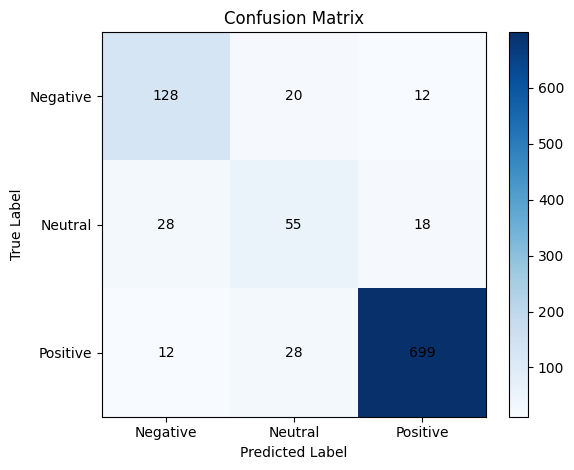

In [ ]:
cm = confusion_matrix(test_df["sentiment_id"], test_preds_1)
labels = ["Negative", "Neutral", "Positive"]

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model
joblib.dump(XGB_distilbert_1, "XGB_finetuned_distilbert_experiment2.pkl")

['XGB_finetuned_distilbert_experiment2.pkl']

In [ ]:
# Add predictions as a new column
test_df["FT_distilbert_pred"] = test_preds_1

# Save to CSV
test_df.to_csv("XGB_distilbert_preds_experiment2.csv", index=False)

In [ ]:
test_df.to_csv("XGB_distilbert_preds_experiment2.csv", index=False)

### Save full pipeline

In [ ]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

XGB_distilbert_1 = joblib.load("XGB_finetuned_distilbert_experiment2.pkl")

class DistilBertVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, batch_size=32):
        self.batch_size = batch_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return get_embeddings(list(X), batch_size=self.batch_size)

pipeline_full = Pipeline([
    ("embed", DistilBertVectorizer(batch_size=32)),
    ("clf",   XGB_distilbert_1)
])

joblib.dump(pipeline_full, "distilbert_XGB_full_pipeline_experiment2.pkl")
print("Saved end-to-end pipeline to 'distilbert_XGB_full_pipeline_experiment2.pkl'")

Saved end-to-end pipeline to 'distilbert_XGB_full_pipeline_experiment2.pkl'


In [ ]:
joblib.dump(pipeline_full, "distilbert_XGB_full_pipeline_experiment2.pkl")

['/content/drive/MyDrive/distilbert_XGB_full_pipeline_experiment2.pkl']